In [ ]:
# !pip install segmentation-models

In [1]:
# from unet import simple_unet_model
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

import tensorflow as tf
import pandas as pd
import glob
from sklearn.model_selection import train_test_split

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3

In [3]:
import cv2

# Define the desired shape
def img_read(path):
    desired_shape = (IMG_WIDTH, IMG_HEIGHT)

    # Load the image
    image = cv2.imread(path,)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # Resize the image to the desired shape
    desired_size = (IMG_WIDTH, IMG_HEIGHT)



    # Convert the image to a numpy array for further processing
    return cv2.resize(img,desired_shape, interpolation=cv2.INTER_AREA)
def msk_read(path):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    desired_size = (IMG_WIDTH, IMG_HEIGHT)
 
    resized_image = cv2.resize(img, desired_size, interpolation=cv2.INTER_AREA)

    # Convert the image to a numpy array for further processing
    return resized_image

In [4]:
large_image_stack = []
large_mask_stack = []
import os
mask_file_names=os.listdir("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\mask_aug\\")
X=[]
y=[]

for i in mask_file_names:
    try:
        p=os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\img_aug\\",i)
        X.append(os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\img_aug\\",i))
        y.append(os.path.join("Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\mask_aug\\",i))
        
        
    except:
        print(f'{i} does not exist in image')



for file_path in X:   
    #print('0')
    signal = img_read(file_path)/255.
    
    large_image_stack.append(signal)


for file_path in y:   
    #print('1')
    signal = msk_read(file_path)/255.
    large_mask_stack.append(signal)
   


In [5]:
large_image_stack=np.array(large_image_stack)
large_mask_stack=np.array(large_mask_stack)
large_mask_stack=np.expand_dims(large_mask_stack, -1)

In [6]:
# all_img_patches = []
# for img in range(large_image_stack.shape[0]):
#     #print(img)     #just stop here to see all file names printed
     
#     large_image = large_image_stack[img]
    
#     patches_img = patchify(large_image, (512, 512,3), step=256)  #Step=256 for 256 patches means no overlap
#     patches_img=np.squeeze(patches_img)

#     for i in range(patches_img.shape[0]):
#         for j in range(patches_img.shape[1]):
            
#             single_patch_img = patches_img[i,j,:,:]
# #             single_patch_img = single_patch_img / 255.
            
#             all_img_patches.append(single_patch_img)

In [7]:
large_image_stack.shape

(1480, 512, 512, 3)

In [8]:
# all_img_patches=np.array(all_img_patches)
# all_mask_patches=np.array(all_mask_patches)
# all_mask_patches=np.expand_dims(all_mask_patches,-1)

In [9]:
large_image_stack.shape, large_mask_stack.shape

((1480, 512, 512, 3), (1480, 512, 512, 1))

In [10]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [11]:
BACKBONE='resnet34'
preprocess_input1=sm.get_preprocessing(BACKBONE)


In [12]:
images1=preprocess_input1(large_image_stack)

In [13]:
X_train, X_test, y_train, y_test=train_test_split(images1,large_mask_stack,random_state=42, test_size=0.25)

In [14]:
X_train_g=X_train #[:,:,:,1]
X_test_g=X_test
# X_test_g=np.expand_dims(X_test[:,:,:,1],-1)

In [15]:
# X_train_g=np.zeros_like(X_train)
# X_train_g[:,:, :, 1]=X_train[:,:, :, 1]
# X_test_g=np.zeros_like(X_test)

# X_train_g[:,:, :, 1]=X_train[:,:, :, 1]
# X_test_g[:,:, :, 1]=X_test[:,:, :, 1]

In [16]:
X_train_g.shape,y_train.shape,X_test_g.shape,y_test.shape

((1110, 512, 512, 3),
 (1110, 512, 512, 1),
 (370, 512, 512, 3),
 (370, 512, 512, 1))

In [ ]:
sm.

In [17]:
import random
import numpy as np

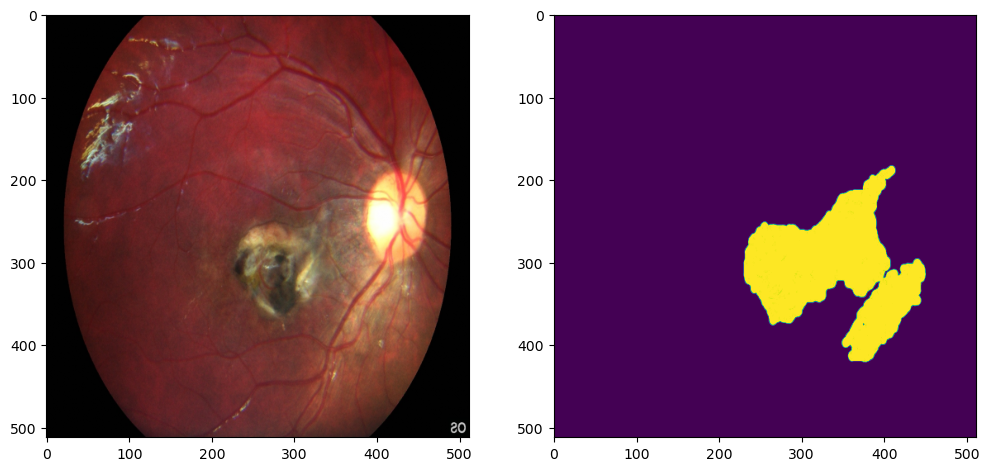

In [18]:
rng=random.randint(0,X_train_g.shape[0])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train_g[rng],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[rng]);

In [19]:
seed=24
from keras.preprocessing.image import ImageDataGenerator


# img_data_gen_args=dict(
#                       rotation_range=90,

# #                       shear_range=0.5,
#                       zoom_range=0.3,
#                       horizontal_flip=True,
#                       vertical_flip=True,
# #                       fill_mode='reflect'
#                       )


# mask_data_gen_args=dict(
#                       rotation_range=90,
#                       width_shift_range=0.3,
#                       height_shift_range=0.3,
# #                       shear_range=0.5,
#                       zoom_range=0.3,
#                       horizontal_flip=True,
#                       vertical_flip=True,
# #                       fill_mode='reflect',
#                        preprocessing_function=lambda x:np.where(x>0,1,0).astype(x.dtype))

In [20]:
image_data_generator=ImageDataGenerator()
image_data_generator.fit(X_train,augment=False,seed=seed)

image_generator=image_data_generator.flow(X_train_g,seed=seed)
valid_img_generator=image_data_generator.flow(X_test,seed=seed)

In [21]:
mask_data_generator=ImageDataGenerator()
mask_data_generator.fit(y_train,augment=False,seed=seed)

mask_generator=mask_data_generator.flow(y_train,seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test,seed=seed)

In [22]:
def my_image_generator(image_generator, mask_generator):
    train_generator=zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        yield (img, mask)

In [23]:
my_generator=my_image_generator(image_generator, mask_generator)

validation_datagen=my_image_generator(valid_img_generator, valid_mask_generator)

(512, 512, 3)


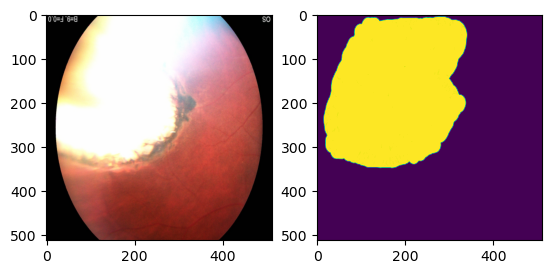

In [24]:
x=image_generator.next()
y=mask_generator.next()

for i in range(0,1):
    image=x[i]
    mask=y[i]
    print(image.shape)
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

In [27]:
model=sm.Unet(BACKBONE,encoder_weights='imagenet')

model.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_17[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_40 (ZeroPadding  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 2D)                            64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_19[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_20[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_46 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_23 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_23[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_52 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_26[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_58 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_29[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_64 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_stage1_concat (Concate  (None, None, None,   0          ['decoder_stage1_upsampling[0][0]
 nate)                          384)                             ',                               
                                                                  'stage3_unit1_relu1[0][0]']     
          

                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage4b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage4a_relu[0][0]']   
                                16)                                                               
          

In [28]:
callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
#     tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\working\\model-Xfer_dice_loss.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history=model.fit(my_generator,validation_data=validation_datagen,steps_per_epoch=50,validation_steps=50, epochs=100,callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 0.9965 - iou_score: 0.2525
Epoch 1: val_loss improved from inf to 32.03656, saving model to Ocular_Toxoplasmosis_Data_V3\segmentation_task\working\model-Xfer_dice_loss.h5
50/50 [==============================] - 52s 946ms/step - loss: 0.9965 - iou_score: 0.2525 - val_loss: 32.0366 - val_iou_score: 0.0749
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.5637 - iou_score: 0.5427
Epoch 2: val_loss did not improve from 32.03656
50/50 [==============================] - 46s 925ms/step - loss: 0.5637 - iou_score: 0.5427 - val_loss: 208.8610 - val_iou_score: 0.0754
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.4942 - iou_score: 0.6080
Epoch 3: val_loss improved from 32.03656 to 4.26650, saving model to Ocular_Toxoplasmosis_Data_V3\segmentation_task\working\model-Xfer_dice_loss.h5
50/50 [==============================] - 47s 938ms/step - loss: 0.4942 - iou_score: 0.6080 - val_loss

50/50 [==============================] - 50s 995ms/step - loss: 0.1479 - iou_score: 0.8818 - val_loss: 0.3116 - val_iou_score: 0.7782
Epoch 27/100
50/50 [==============================] - ETA: 0s - loss: 0.1333 - iou_score: 0.8928
Epoch 27: val_loss improved from 0.31158 to 0.29431, saving model to Ocular_Toxoplasmosis_Data_V3\segmentation_task\working\model-Xfer_dice_loss.h5
50/50 [==============================] - 50s 1s/step - loss: 0.1333 - iou_score: 0.8928 - val_loss: 0.2943 - val_iou_score: 0.7867
Epoch 28/100
50/50 [==============================] - ETA: 0s - loss: 0.1295 - iou_score: 0.8961
Epoch 28: val_loss improved from 0.29431 to 0.29097, saving model to Ocular_Toxoplasmosis_Data_V3\segmentation_task\working\model-Xfer_dice_loss.h5
50/50 [==============================] - 50s 1s/step - loss: 0.1295 - iou_score: 0.8961 - val_loss: 0.2910 - val_iou_score: 0.7992
Epoch 29/100
50/50 [==============================] - ETA: 0s - loss: 0.1207 - iou_score: 0.9029
Epoch 29: val_los

50/50 [==============================] - ETA: 0s - loss: 0.2296 - iou_score: 0.8190
Epoch 53: val_loss did not improve from 0.23463
50/50 [==============================] - 49s 991ms/step - loss: 0.2296 - iou_score: 0.8190 - val_loss: 1.5171 - val_iou_score: 0.3026
Epoch 54/100
50/50 [==============================] - ETA: 0s - loss: 0.2922 - iou_score: 0.7708
Epoch 54: val_loss did not improve from 0.23463
50/50 [==============================] - 49s 992ms/step - loss: 0.2922 - iou_score: 0.7708 - val_loss: 10.8876 - val_iou_score: 0.1145
Epoch 55/100
50/50 [==============================] - ETA: 0s - loss: 0.2513 - iou_score: 0.8027
Epoch 55: val_loss did not improve from 0.23463
50/50 [==============================] - 49s 993ms/step - loss: 0.2513 - iou_score: 0.8027 - val_loss: 1.5606 - val_iou_score: 0.2850
Epoch 56/100
50/50 [==============================] - ETA: 0s - loss: 0.1968 - iou_score: 0.8432
Epoch 56: val_loss did not improve from 0.23463
50/50 [=======================

KeyboardInterrupt: 

In [31]:
model=tf.keras.models.load_model('Ocular_Toxoplasmosis_Data_V3\\segmentation_task\\working\\model-Xfer_dice_loss.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000028A54E6E288>.

In [32]:
y_pred=model.predict(X_test)

12/12 [==============================] - 3s 195ms/step


In [43]:
y_pred_thresh=y_pred>0.5
intersection=np.logical_and(y_test,y_pred_thresh)
union=np.logical_or(y_test,y_pred_thresh)
iou=np.sum(intersection)/np.sum(union)
iou

0.801350346025862

1/1 [==============================] - 0s 28ms/step


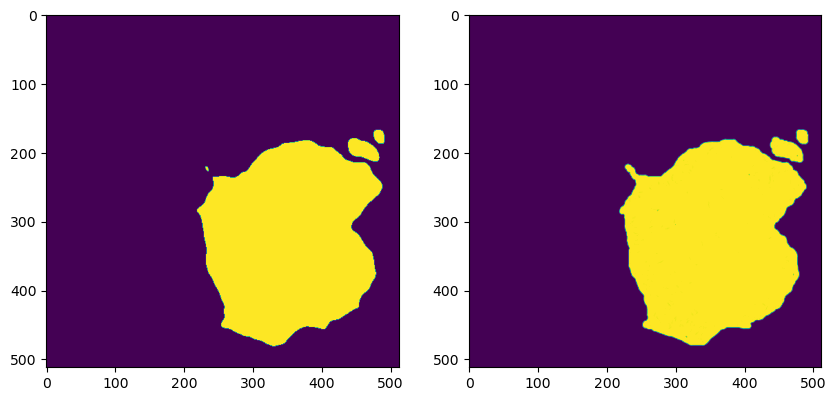

In [53]:
test_img_num=random.randint(0,len(X_test)-1)
test_img=X_test[test_img_num]
test_img_input=np.expand_dims(test_img,0)
gt=y_test[test_img_num]
yp=model.predict(test_img_input)

plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(yp[0,:,:,0]>.5)
plt.subplot(122)
plt.imshow(gt[:,:,0])


In [ ]:
yp.shape

In [ ]:
plt.imshow(yp[0,:,:,0])

In [ ]:
plt.imshow(gt[:,:,0])

In [ ]:
gt.shape